<a href="https://colab.research.google.com/github/giovanibrmiguel/sus-news-detector/blob/main/Suspicious_News_Detector_One_Class_SVM_model_(Discovery_Notebook).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing main libraries

In [ ]:
import pandas as pd
import numpy as np
import time
import collections
from google.colab import files
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.svm import OneClassSVM
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, normalize
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score

from xgboost import XGBClassifier

from wordcloud import WordCloud

Importing libs for Google Drive

In [ ]:
#!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


## Count Vectorizer model with SVM

Here we are experimenting on One Class Support Vector Machines to train/test prediction of Suspicious News on a dataset modeled using Count Vectorizer method. Later we found that Count Vectorizer had a better outcome than TF-IDF since our news have different lenghts.

### Creating Count Vectorizer train and test dataframes

In [ ]:
#importing the countvec df file from driver shared link

link = 'https://drive.google.com/file/d/1lzhavMgq4XG9YYTEGRNHLHBoupU_65fB/view?usp=sharing'

# to get the id part of the file
id = link.split("/")[-2]
  
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('df_countvec_texts.csv')  
  
countvec_texts = pd.read_csv('df_countvec_texts.csv')
print(countvec_texts)

KeyboardInterrupt: ignored

In [ ]:
#importing the countvec df file from driver shared link

link = 'https://drive.google.com/file/d/1czJ7AeTILudvfK8N3AEgbNy_-JDkOJ6j/view?usp=sharing'

# to get the id part of the file
id = link.split("/")[-2]
  
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('df_countvec_fake.csv')  
  
countvec_fake = pd.read_csv('df_countvec_fake.csv')
print(countvec_fake)

In [ ]:
#importing the countvec df test (true news) file from driver shared link

link = 'https://drive.google.com/file/d/1kKHADXd20_T-jNm0R5Jwg6yoV58SEbwq/view?usp=sharing'

# to get the id part of the file
id = link.split("/")[-2]
  
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('df_countvec_texts_test.csv')  
  
countvec_texts_test = pd.read_csv('df_countvec_texts_test.csv')
print(countvec_texts_test)

In [ ]:
X_train_cv = countvec_texts.set_index('Unnamed: 0')
X_test_cv = countvec_fake.set_index('Unnamed: 0')

###Calling One-Class SVM

In [ ]:
one_class_svm = OneClassSVM(kernel='rbf', degree=3, gamma='scale')

In [ ]:
one_class_svm.fit(X_train_cv)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma='scale', kernel='rbf',
            max_iter=-1, nu=0.5, shrinking=True, tol=0.001, verbose=False)

In [ ]:
pred = one_class_svm.predict(X_test_cv)
collections.Counter(pred)

Counter({-1: 22, 1: 18})

###Preparing train and test datasets

In [ ]:
# importing true and fake news datasets
df_true_news = countvec_texts.set_index('Unnamed: 0')
df_true_news_test = countvec_texts_test.set_index('Unnamed: 0')
df_fake_news = countvec_fake.set_index('Unnamed: 0')

# adding true or fake news labels (-1 = fake, 1 = true)
df_true_news['label_class'] = 1
df_true_news_test['label_class'] = 1
df_fake_news['label_class'] = -1

# setting training datasets
X_train = df_true_news.drop(['label_class'], axis = 1)
y_train = df_true_news['label_class']

# joining 40 true news with 40 fake for test dataset
df_test = df_fake_news.append(df_true_news_test.sample(n=40, random_state=42))
X_test = df_test.drop(['label_class'], axis = 1)
y_test = df_test['label_class']

### Aplying SVM

In [ ]:
one_class_svm = OneClassSVM(kernel='rbf', degree=3, gamma='scale')
one_class_svm.fit(X_train)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma='scale', kernel='rbf',
            max_iter=-1, nu=0.5, shrinking=True, tol=0.001, verbose=False)

In [ ]:
y_pred = one_class_svm.predict(X_test)
collections.Counter(y_pred)

Counter({-1: 37, 1: 43})

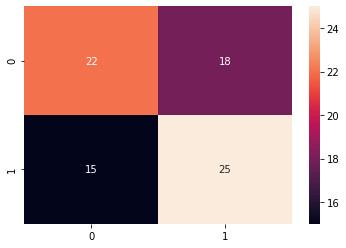

In [ ]:
sns.heatmap(confusion_matrix(y_test,y_pred), annot = True)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.59      0.55      0.57        40
           1       0.58      0.62      0.60        40

    accuracy                           0.59        80
   macro avg       0.59      0.59      0.59        80
weighted avg       0.59      0.59      0.59        80



###Tunning parameters

Here we tried tuning our parameters using GridSearch. We found that since our Train DF only has one type of class (inliers), GridSearch suggested as best parameters the one that called all data as inliers, and had a poor result on Test DF (same thing that happened with XGBoosting)

In [ ]:
tuned_parameters = {#'kernel':['linear','poly','rbf','sigmoid','precomputed'],
                    #'degree':[3,5,7],
                    'gamma': ['scale','auto'],
                    #'coef0': [0.0,5.0,20.0],
                    'nu':[0.1, 0.5],
                    'verbose':[True]}

one_class_svm = GridSearchCV(OneClassSVM(),tuned_parameters, scoring='accuracy')
one_class_svm.fit(X_train,y_train)

print('Best parameters:',one_class_svm.best_params_)
print('Best accuracy:',one_class_svm.best_score_)

In [ ]:
one_class_svm = OneClassSVM(gamma='auto', nu = 0.1, verbose = True)

one_class_svm.fit(X_train)

y_pred = one_class_svm.predict(X_test)

print(classification_report(y_test, y_pred))

[LibSVM]              precision    recall  f1-score   support

          -1       0.75      0.23      0.35        40
           1       0.54      0.93      0.69        40

    accuracy                           0.57        80
   macro avg       0.65      0.58      0.52        80
weighted avg       0.65      0.57      0.52        80



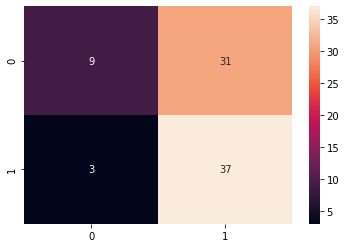

In [ ]:
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True)

 testando aumentar o nu

In [ ]:
one_class_svm = OneClassSVM(gamma='auto', nu = 0.3, verbose = True)

one_class_svm.fit(X_train)

y_pred = one_class_svm.predict(X_test)

print(classification_report(y_test, y_pred))

[LibSVM]              precision    recall  f1-score   support

          -1       0.67      0.40      0.50        40
           1       0.57      0.80      0.67        40

    accuracy                           0.60        80
   macro avg       0.62      0.60      0.58        80
weighted avg       0.62      0.60      0.58        80



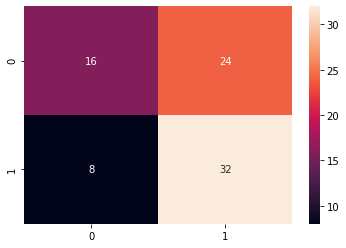

In [ ]:
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True)

##Count Vec with XGBoosting

Here we are experimenting using XGBoosting to improve our model results. We found out that, since our Train DF is only composed of inliers (and our Test DF has inliers and outliers), XGBoosting did not gave us the best results. XGBoosting simply calls all news as inliers, since it was trained using a DF with only inliers.

In [ ]:
# importing true and fake news datasets
df_true_news = countvec_texts.set_index('Unnamed: 0')
df_true_news_test = countvec_texts_test.set_index('Unnamed: 0')
df_fake_news = countvec_fake.set_index('Unnamed: 0')

# adding true or fake news labels (-1 = fake, 1 = true)
df_true_news['label_class'] = 1
df_true_news_test['label_class'] = 1
df_fake_news['label_class'] = -1

# setting training datasets
X_train = df_true_news.drop(['label_class'], axis = 1)
y_train = df_true_news['label_class']

# joining 40 true news with 40 fake for test dataset
df_test = df_fake_news.append(df_true_news_test.sample(n=40, random_state=42))
X_test = df_test.drop(['label_class'], axis = 1)
y_test = df_test['label_class']

In [ ]:
xgb_classifier = XGBClassifier(random_state=42, eval_metric='mlogloss')
xgb_classifier.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='mlogloss',
              gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

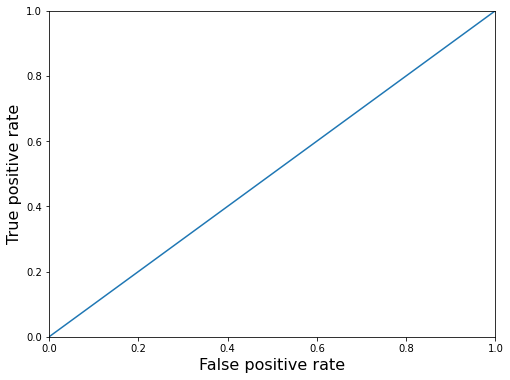

In [ ]:
y_pred = xgb_classifier.predict(X_test)
p_pred = xgb_classifier.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, p_pred)

plt.subplots(figsize=(8,6))
plt.plot(fpr, tpr)
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('False positive rate', fontsize = 16)
plt.ylabel('True positive rate', fontsize = 16)
plt.show()

In [ ]:
print('Auc: ', auc(fpr, tpr))

Auc:  0.5


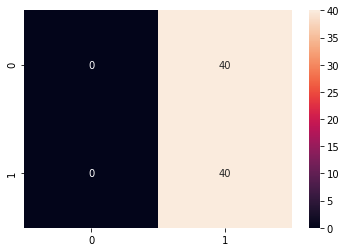

In [ ]:
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True);

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        40
           1       0.50      1.00      0.67        40

    accuracy                           0.50        80
   macro avg       0.25      0.50      0.33        80
weighted avg       0.25      0.50      0.33        80



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## TF-IDF Model with SVM

Here we are experimenting on One Class Support Vector Machines to train/test prediction of Suspicious News on a dataset modeled using TF IDF method. Here we found that Count Vectorizer had a better outcome than TF-IDF since our news have different lenghts and this might be a problem, since TF-IDF relies on relative frequencies.

##### Importing TF IDF datasets




In [ ]:
#importing the tf_idf df file from driver shared link

link = 'https://drive.google.com/file/d/1btYwZwSg2N54oD_iA5tozqzjYQX_2fSM/view?usp=sharing'

# to get the id part of the file
id = link.split("/")[-2]
  
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('df_tf_idf_texts.csv')  
  
tf_idf_texts = pd.read_csv('df_tf_idf_texts.csv')
print(tf_idf_texts)

      Unnamed: 0    a  vacinação  ...  temperamento  disfarçada  fritando
0              0  0.0   0.000000  ...           0.0         0.0       0.0
1              1  0.0   0.000000  ...           0.0         0.0       0.0
2              2  0.0   0.000000  ...           0.0         0.0       0.0
3              3  0.0   0.000000  ...           0.0         0.0       0.0
4              4  0.0   0.000000  ...           0.0         0.0       0.0
...          ...  ...        ...  ...           ...         ...       ...
1255        1255  0.0   0.050189  ...           0.0         0.0       0.0
1256        1256  0.0   0.000000  ...           0.0         0.0       0.0
1257        1257  0.0   0.093116  ...           0.0         0.0       0.0
1258        1258  0.0   0.000000  ...           0.0         0.0       0.0
1259        1259  0.0   0.000000  ...           0.0         0.0       0.0

[1260 rows x 48303 columns]


In [ ]:
  #importing the countvec df file from driver shared link

link = 'https://drive.google.com/file/d/1B0Te55__fUjVDrE_Dw_ARxtLFtZhmhwJ/view?usp=sharing'

# to get the id part of the file
id = link.split("/")[-2]
  
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('df_tf_idf_fake.csv')  
  
tf_idf_fake = pd.read_csv('df_tf_idf_fake.csv')
print(tf_idf_fake)

    Unnamed: 0    a  vacinação  ...  temperamento  disfarçada  fritando
0            0  0.0   0.000000  ...           0.0         0.0       0.0
1            1  0.0   0.000000  ...           0.0         0.0       0.0
2            2  0.0   0.026020  ...           0.0         0.0       0.0
3            3  0.0   0.000000  ...           0.0         0.0       0.0
4            4  0.0   0.000000  ...           0.0         0.0       0.0
5            5  0.0   0.000000  ...           0.0         0.0       0.0
6            6  0.0   0.000000  ...           0.0         0.0       0.0
7            7  0.0   0.000000  ...           0.0         0.0       0.0
8            8  0.0   0.000000  ...           0.0         0.0       0.0
9            9  0.0   0.000000  ...           0.0         0.0       0.0
10          10  0.0   0.000000  ...           0.0         0.0       0.0
11          11  0.0   0.000000  ...           0.0         0.0       0.0
12          12  0.0   0.000000  ...           0.0         0.0   

In [ ]:
#importing the tf_idf df test (true news) file from driver shared link

link = 'https://drive.google.com/file/d/12VP3AZjTA8QEZ1NGhHCuKtemJB51rIoY/view?usp=sharing'

# to get the id part of the file
id = link.split("/")[-2]
  
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('df_tf_idf_texts_test.csv')  
  
tf_idf_texts_test = pd.read_csv('df_tf_idf_texts_test.csv')
print(tf_idf_texts_test)

      Unnamed: 0    a  vacinação  ...  temperamento  disfarçada  fritando
0              0  0.0   0.105703  ...      0.000000    0.000000  0.000000
1              1  0.0   0.000000  ...      0.000000    0.000000  0.000000
2              2  0.0   0.054233  ...      0.000000    0.000000  0.000000
3              3  0.0   0.000000  ...      0.000000    0.000000  0.000000
4              4  0.0   0.187317  ...      0.000000    0.000000  0.000000
...          ...  ...        ...  ...           ...         ...       ...
1756        1756  0.0   0.140488  ...      0.000000    0.000000  0.000000
1757        1757  0.0   0.021214  ...      0.000000    0.000000  0.000000
1758        1758  0.0   0.000000  ...      0.000000    0.000000  0.000000
1759        1759  0.0   0.063500  ...      0.000000    0.000000  0.000000
1760        1760  0.0   0.000000  ...      0.061663    0.061663  0.061663

[1761 rows x 48303 columns]


###Calling One-Class SVM

In [ ]:
X_train_tf = tf_idf_texts.set_index('Unnamed: 0')
X_test_tf = tf_idf_fake.set_index('Unnamed: 0')

In [ ]:
one_class_svm = OneClassSVM(kernel='rbf', degree=3, gamma='scale')

In [ ]:
one_class_svm.fit(X_train_tf)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma='scale', kernel='rbf',
            max_iter=-1, nu=0.5, shrinking=True, tol=0.001, verbose=False)

Applying model without adjusting parameters. it identifies 72.5% of fake news as fake

In [ ]:
pred = one_class_svm.predict(X_test_tf)
collections.Counter(pred)

Counter({-1: 29, 1: 11})

###PCA methodology

We experimented using PCA to reduce dimensions so we can easily find outliers and remove them from our dataset. In the end of this section, it was found that PCA was only effective (i.e. represent most of our variance) if we did a PCA to consider a large number of columns (i.e. words). If we choose to created that many PCA features, we won't be able to do so, because we'll have more columns than rows (texts) on our test dataset. Thus, we decided to not apply PCA in the end.

In [ ]:
# Applying PCA

# Instancing model
pca2 = PCA(n_components = 2)

# Using std scaler
std_scaler = StandardScaler()
X_train_tf_pca2 = std_scaler.fit_transform(X_train_tf)
X_test_tf_pca2 = std_scaler.fit_transform(X_test_tf)


# Adjusting with train data
X_train_tf_pca2 = pca2.fit_transform(X_train_tf_pca2)
X_test_tf_pca2 = pca2.fit_transform(X_test_tf_pca2)

In [ ]:
one_class_svm.fit(X_train_tf_pca2)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma='scale', kernel='rbf',
            max_iter=-1, nu=0.5, shrinking=True, tol=0.001, verbose=False)

The model with PCA identified 100% of fake news as fake

In [ ]:
pred = one_class_svm.predict(X_test_tf_pca2)
collections.Counter(pred)

Counter({-1: 40})

In [ ]:
one_class_svm.fit(X_train_tf_pca2)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma='scale', kernel='rbf',
            max_iter=-1, nu=0.5, shrinking=True, tol=0.001, verbose=False)

In [ ]:
pred = one_class_svm.predict(X_train_tf_pca2)
collections.Counter(pred)

Counter({-1: 630, 1: 630})

In [ ]:
pred = np.expand_dims(pred, axis = 1)
X_train_tf_pca2 = np.append(X_train_tf_pca2, pred, axis = 1) 

Via PCA we can see we have two outlier texts that should be removed from our true dataseta


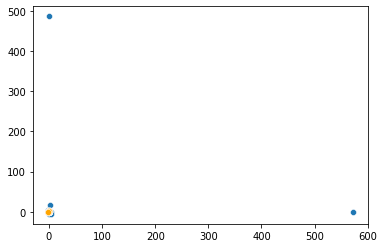

In [ ]:
sns.scatterplot(x=X_train_tf_pca2[:,0], y=X_train_tf_pca2[:,1])
sns.scatterplot(x=X_train_tf_pca2[:,2],  y=X_train_tf_pca2[:,2], color='orange')

In [ ]:
X_train_tf_pca2 = pd.DataFrame(X_train_tf_pca2)

Index 829 and 43 texts are outliers

In [ ]:
X_train_tf_pca2.sort_values(by= 0 , ascending = False)

,0,1,2
829,571.570479,0.103537,-1.0
720,3.055701,-0.906813,-1.0
939,3.017420,-5.350347,-1.0
499,1.995344,-0.464521,-1.0
784,1.715813,-0.982456,-1.0
...,...,...,...
135,-1.013279,1.017209,-1.0
241,-1.076275,-1.691188,-1.0
224,-1.233312,-1.790232,-1.0
146,-1.241510,-1.748819,-1.0


In [ ]:
X_train_tf_pca2.drop([43], inplace = True)
X_train_tf_pca2.drop([829], inplace = True)

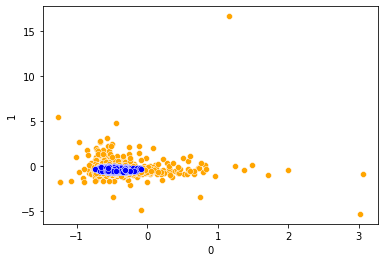

In [ ]:
sns.scatterplot(x=X_train_tf_pca2[X_train_tf_pca2[2] == -1][0], y=X_train_tf_pca2[X_train_tf_pca2[2] == -1][1], color = 'orange')
sns.scatterplot(x=X_train_tf_pca2[X_train_tf_pca2[2] == 1][0], y=X_train_tf_pca2[X_train_tf_pca2[2] == 1][1], color = 'blue')

### Preparing train and test datasets

In [ ]:
# importing true and fake news datasets
#df_true_news = tf_idf_texts.set_index('Unnamed: 0')
#df_true_news_test = tf_idf_texts_test.set_index('Unnamed: 0')
#df_fake_news = tf_idf_fake.set_index('Unnamed: 0')


# removing two true news outliers
#df_true_news.drop([43], inplace = True)
#df_true_news.drop([829], inplace = True)
#df_true_news.drop([36], inplace = True)
#df_true_news.drop([557], inplace = True)
#df_true_news.drop([287], inplace = True)
#df_true_news.drop([558], inplace = True)

# adding true or fake news labels (-1 = fake, 1 = true)
#df_true_news['label'] = 1
#df_true_news_test['label'] = 1
#df_fake_news['label'] = -1


# selecting 40 random true news from true news dataset which is not into training dataset
#np.random.seed(42)
#true_test_indexes = np.random.choice(df_true_news_test.index, 40, replace=False)
#df_train = df_true_news.drop(drop_indices)
#X_train = df_train.drop(['label'], axis = 1)
#y_train = df_train['label']

# joining 40 true news with 40 fake for test dataset
#df_test = df_fake_news.append(df_true_news.iloc[drop_indices])
#X_test = df_test.drop(['label'], axis = 1)
#y_test = df_test['label']

In [ ]:
# importing true and fake news datasets
df_true_news = tf_idf_texts.set_index('Unnamed: 0')
df_true_news_test = tf_idf_texts_test.set_index('Unnamed: 0')
df_fake_news = tf_idf_fake.set_index('Unnamed: 0')

# adding true or fake news labels (-1 = fake, 1 = true)
df_true_news['label_class'] = 1
df_true_news_test['label_class'] = 1
df_fake_news['label_class'] = -1

# setting training datasets
X_train = df_true_news.drop(['label_class'], axis = 1)
y_train = df_true_news['label_class']

# joining 40 true news with 40 fake for test dataset
df_test = df_fake_news.append(df_true_news_test.sample(n=40, random_state=42))
X_test = df_test.drop(['label_class'], axis = 1)
y_test = df_test['label_class']

### Applying SVM

In [ ]:
one_class_svm = OneClassSVM(kernel='rbf', degree=3, gamma='scale')
one_class_svm.fit(X_train)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma='scale', kernel='rbf',
            max_iter=-1, nu=0.5, shrinking=True, tol=0.001, verbose=False)

In [ ]:
y_pred = one_class_svm.predict(X_test)
collections.Counter(y_pred)

Counter({-1: 56, 1: 24})

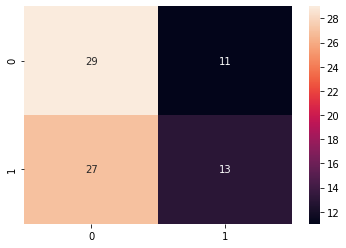

In [ ]:
sns.heatmap(confusion_matrix(y_test,y_pred), annot = True)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.52      0.72      0.60        40
           1       0.54      0.33      0.41        40

    accuracy                           0.53        80
   macro avg       0.53      0.53      0.51        80
weighted avg       0.53      0.53      0.51        80



In general, the one-class SVM with no tunned parameters has performed with an accuracy of 53% in the test dataset.

### Tunning parameters

Here we tried tuning our parameters using GridSearch. We found that since our Train DF only has one type of class (inliers), GridSearch suggested as best parameters the one that called all data as inliers, and had a poor result on Test DF (same thing that happened with XGBoosting)

In [ ]:
tuned_parameters = {#'kernel':['linear','poly','rbf','sigmoid','precomputed'],
                    #'degree':[3,5,7],
                    'gamma': ['scale','auto'],
                    #'coef0': [0.0,5.0,20.0],
                    'nu':[0.1, 0.5],
                    'verbose':[True]}

one_class_svm = GridSearchCV(OneClassSVM(),tuned_parameters, scoring='accuracy')
one_class_svm.fit(X_train,y_train)

print('Best parameters:',one_class_svm.best_params_)
print('Best accuracy:',one_class_svm.best_score_)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Best parameters: {'gamma': 'scale', 'nu': 0.1, 'verbose': True}
Best accuracy: 0.7071428571428571


In [ ]:
one_class_svm = OneClassSVM(gamma='scale', nu = 0.1, verbose = True)

one_class_svm.fit(X_train)

y_pred = one_class_svm.predict(X_test)

print(classification_report(y_test, y_pred))

[LibSVM]              precision    recall  f1-score   support

          -1       0.57      0.42      0.49        40
           1       0.54      0.68      0.60        40

    accuracy                           0.55        80
   macro avg       0.55      0.55      0.54        80
weighted avg       0.55      0.55      0.54        80



Tunning parameters, we could improve accuracy to 55%.

This is the best results so far in terms of precision (nu = 0.3)

In [ ]:
one_class_svm = OneClassSVM(gamma='scale', nu = 0.3, verbose=True)

one_class_svm.fit(X_train)

y_pred = one_class_svm.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.56      0.62      0.59        40
           1       0.57      0.50      0.53        40

    accuracy                           0.56        80
   macro avg       0.56      0.56      0.56        80
weighted avg       0.56      0.56      0.56        80



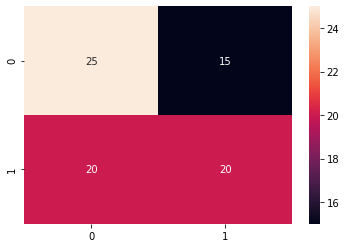

In [ ]:
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True)

In [ ]:
y_pred = one_class_svm.predict(X_train)

print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           1       1.00      0.70      0.82      1260

    accuracy                           0.70      1260
   macro avg       0.50      0.35      0.41      1260
weighted avg       1.00      0.70      0.82      1260



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##TF-IDF Model with XGBoosting

The same issue with XGBoosting on Count Vectorizer model was found here.

In [ ]:
# importing true and fake news datasets
df_true_news = tf_idf_texts.set_index('Unnamed: 0')
df_true_news_test = tf_idf_texts_test.set_index('Unnamed: 0')
df_fake_news = tf_idf_fake.set_index('Unnamed: 0')

# adding true or fake news labels (-1 = fake, 1 = true)
df_true_news['label_class'] = 1
df_true_news_test['label_class'] = 1
df_fake_news['label_class'] = -1

# setting training datasets
X_train = df_true_news.drop(['label_class'], axis = 1)
y_train = df_true_news['label_class']

# joining 40 true news with 40 fake for test dataset
df_test = df_fake_news.append(df_true_news_test.sample(n=40, random_state=42))
X_test = df_test.drop(['label_class'], axis = 1)
y_test = df_test['label_class']

In [ ]:
xgb_classifier = XGBClassifier(random_state=42, eval_metric='mlogloss')
xgb_classifier.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='mlogloss',
              gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

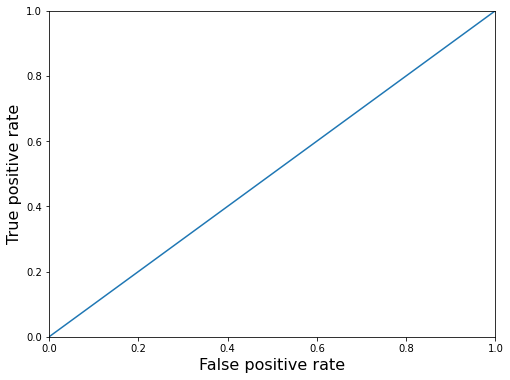

In [ ]:
y_pred = xgb_classifier.predict(X_test)
p_pred = xgb_classifier.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, p_pred)

plt.subplots(figsize=(8,6))
plt.plot(fpr, tpr)
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('False positive rate', fontsize = 16)
plt.ylabel('True positive rate', fontsize = 16)
plt.show()

In [ ]:
print('Auc: ', auc(fpr, tpr))

Auc:  0.5


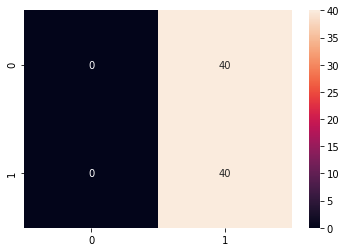

In [ ]:
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True);

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        40
           1       0.50      1.00      0.67        40

    accuracy                           0.50        80
   macro avg       0.25      0.50      0.33        80
weighted avg       0.25      0.50      0.33        80



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Analyzing the results above, none of the news were considered suspect to be fake news.

###TF-IDF Model with XGBoosting - Train and test remodeling

In [ ]:
df_news = df_true_news.append(df_fake_news)
df_news.head()

,a,vacinação,toda,população,quilombola,pautas,debatidas,abrasco,desde,começo,pandemia,meio,gt,racismo,saúde,enfrenta,novos,desafios,nesta,semana,ministro,supremo,tribunal,federal,edson,fachin,determinou,quilombolas,vivem,comunidades,incluídos,plano,nacional,imunização,pni,enfrentamento,epidemia,covid,19,o,...,motorizada,proclamou,gritarem,ensaiados,exultou,pulando,empolgado,mirou,chiqueiro,despiorando,curvou,drones,viaturas,superlotando,alegremente,passeando,divertindo,clandestinos,desmobilizadas,infringir,dm9xs0rsqm,tolo,ouroditolo,variavam,incomodasse,infotracker,capivari,santarsiere,away,endurecer,padovan,largou,publisher,cachimbo,obrigatoriedades,motociatas,temperamento,disfarçada,fritando,label_class
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.000000,0.142414,0.0,0.0,0.0,0.047471,0.000000,0.0,0.047471,0.023736,0.000000,0.0,0.142414,0.0,0.023736,0.000000,0.0,0.047471,0.023736,0.0,0.0,0.023736,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.047471,0.166149,0.166149,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.0,0.0,0.028868,0.028868,0.0,0.0,0.0,0.028868,0.000000,0.0,0.259808,0.000000,0.000000,0.0,0.057735,0.0,0.028868,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.028868,0.057735,0.0,0.0,0.028868,0.000000,0.259808,0.259808,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.080322,0.000000,0.0,0.080322,0.000000,0.000000,0.0,0.080322,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.160644,0.080322,0.080322,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.0,0.0,0.000000,0.036346,0.0,0.0,0.0,0.072691,0.036346,0.0,0.218074,0.000000,0.000000,0.0,0.254419,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.036346,0.0,0.000000,0.036346,0.0,0.0,0.000000,0.036346,0.109037,0.109037,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.0,0.0,0.000000,0.017753,0.0,0.0,0.0,0.159775,0.000000,0.0,0.017753,0.000000,0.035505,0.0,0.585840,0.0,0.000000,0.017753,0.0,0.017753,0.000000,0.0,0.0,0.142022,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.017753,0.195280,0.0,0.0,0.035505,0.000000,0.053258,0.053258,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [ ]:
X = df_news.drop('label_class', axis=1)
y = df_news['label_class']

# split train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

print('X train size: ', X_train.shape)
print('X test size: ', X_test.shape)
print('y train size: ', y_train.shape)
print('y test size: ', y_test.shape)

X train size:  (1105, 48302)
X test size:  (195, 48302)
y train size:  (1105,)
y test size:  (195,)


In [ ]:
xgb_classifier = XGBClassifier(random_state=42, eval_metric='mlogloss')
xgb_classifier.fit(X_train, y_train)

cv = cross_val_score(xgb_classifier, X, y, cv=5)

print("média acurácia durante validação cruzada = ", cv.mean())

média acurácia durante validação cruzada =  0.9707692307692307


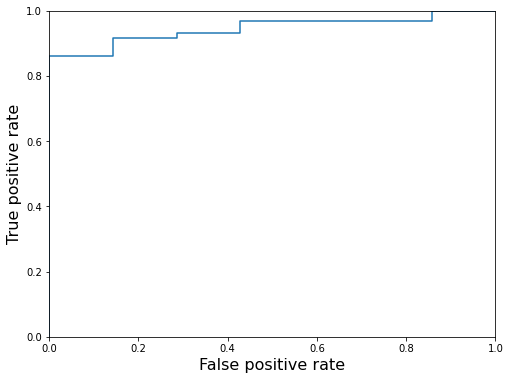

In [ ]:
y_pred = xgb_classifier.predict(X_test)
p_pred = xgb_classifier.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, p_pred)

plt.subplots(figsize=(8,6))
plt.plot(fpr, tpr)
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('False positive rate', fontsize = 16)
plt.ylabel('True positive rate', fontsize = 16)
plt.show()

In [ ]:
print('Auc: ', auc(fpr, tpr))

Auc:  0.9445288753799392


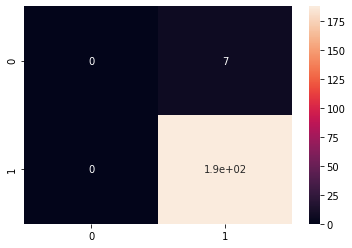

In [ ]:
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True);

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         7
           1       0.96      1.00      0.98       188

    accuracy                           0.96       195
   macro avg       0.48      0.50      0.49       195
weighted avg       0.93      0.96      0.95       195



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


This is the best accuracy we could achieve! **However**, it's fake accuracy due to the fact that the model only considered one classification for every news in the dataset (1 = true news). This happens due to the highly unbalanced dataset remodeled to fit with XG Boosting, where we put together true (1260) and fake (40) and set the train and test split.

**What to do now?** We wil try to apply additional treatment in the database, reducing the number of features where importance is lower.
- Remove less frequent words (features);
- Decide if we will remove less frequent words considering the entire corpus, or only the training dataset.

##TF-IDF Feature Engineering

Here we started with feature engineering to improve our model for TF-IDF.

In [ ]:
# importing true and fake news datasets
df_true_news = tf_idf_texts.set_index('Unnamed: 0')
df_true_news_test = tf_idf_texts_test.set_index('Unnamed: 0')
df_fake_news = tf_idf_fake.set_index('Unnamed: 0')

# creating a full dataset of true news
df_news = df_true_news.append(df_true_news_test).reset_index()
df_news.drop('Unnamed: 0', axis=1, inplace=True)
df_news

,a,vacinação,toda,população,quilombola,pautas,debatidas,abrasco,desde,começo,pandemia,meio,gt,racismo,saúde,enfrenta,novos,desafios,nesta,semana,ministro,supremo,tribunal,federal,edson,fachin,determinou,quilombolas,vivem,comunidades,incluídos,plano,nacional,imunização,pni,enfrentamento,epidemia,covid,19,o,...,amitiu,motorizada,proclamou,gritarem,ensaiados,exultou,pulando,empolgado,mirou,chiqueiro,despiorando,curvou,drones,viaturas,superlotando,alegremente,passeando,divertindo,clandestinos,desmobilizadas,infringir,dm9xs0rsqm,tolo,ouroditolo,variavam,incomodasse,infotracker,capivari,santarsiere,away,endurecer,padovan,largou,publisher,cachimbo,obrigatoriedades,motociatas,temperamento,disfarçada,fritando
0,0.0,0.000000,0.000000,0.142414,0.0,0.0,0.0,0.047471,0.000000,0.0,0.047471,0.023736,0.000000,0.0,0.142414,0.0,0.023736,0.000000,0.000000,0.047471,0.023736,0.0,0.0,0.023736,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.047471,0.166149,0.166149,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.0,0.000000,0.028868,0.028868,0.0,0.0,0.0,0.028868,0.000000,0.0,0.259808,0.000000,0.000000,0.0,0.057735,0.0,0.028868,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.028868,0.057735,0.000000,0.0,0.028868,0.000000,0.259808,0.259808,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.080322,0.000000,0.0,0.080322,0.000000,0.000000,0.0,0.080322,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.160644,0.080322,0.080322,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.0,0.000000,0.000000,0.036346,0.0,0.0,0.0,0.072691,0.036346,0.0,0.218074,0.000000,0.000000,0.0,0.254419,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.036346,0.0,0.000000,0.036346,0.000000,0.0,0.000000,0.036346,0.109037,0.109037,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.0,0.000000,0.000000,0.017753,0.0,0.0,0.0,0.159775,0.000000,0.0,0.017753,0.000000,0.035505,0.0,0.585840,0.0,0.000000,0.017753,0.000000,0.017753,0.000000,0.0,0.0,0.142022,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.017753,0.195280,0.000000,0.0,0.035505,0.000000,0.053258,0.053258,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3016,0.0,0.140488,0.046829,0.093659,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.046829,0.0,0.000000,0.000000,0.000000,0.140488,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.046829,0.000000,0.0,0.000000,0.000000,0.093659,0.140488,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3017,0.0,0.021214,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.021214,0.0,0.1

In [ ]:
sum_tf_idf_indexes = df_news.sum(axis=0)

In [ ]:
sum_tf_idf_indexes

a                     0.000000
vacinação           100.864920
toda                 18.573860
população            85.280797
quilombola            0.466425
                       ...    
obrigatoriedades      0.061663
motociatas            0.061663
temperamento          0.061663
disfarçada            0.061663
fritando              0.061663
Length: 48302, dtype: float64

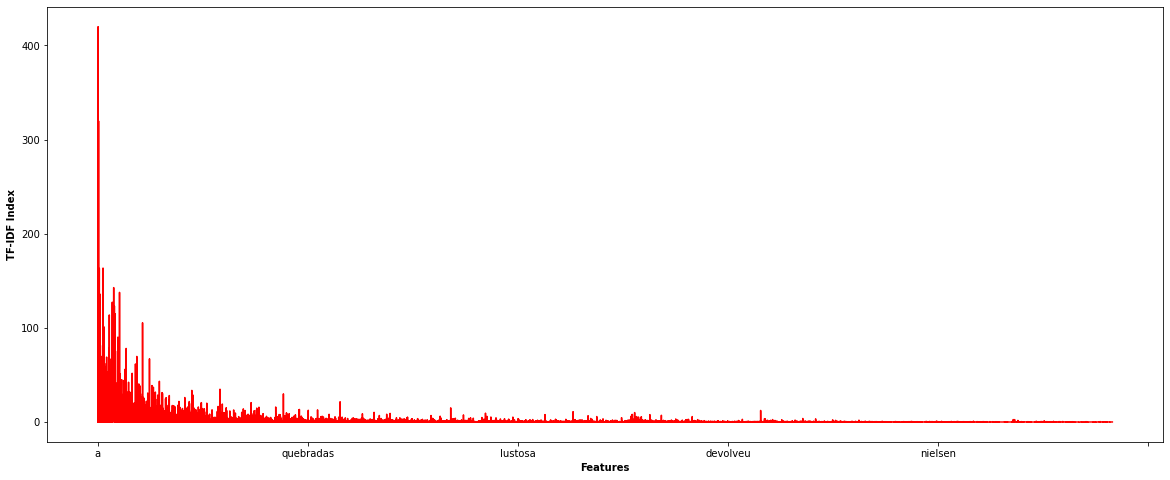

In [ ]:
plt.figure(figsize=(20,8))
sum_tf_idf_indexes.plot(c='red')
plt.xlabel('Features', fontweight='bold')
plt.ylabel('TF-IDF Index', fontweight='bold');

In [ ]:
sum_tf_idf_indexes.describe()

count    48302.000000
mean         0.745022
std          4.949058
min          0.000000
25%          0.030873
50%          0.071931
75%          0.252126
max        419.890637
dtype: float64

In [ ]:
np.percentile(sum_tf_idf_indexes, 2)

0.010109265090722559

In [ ]:
df_drop = pd.DataFrame(columns=df_news.columns)

In [ ]:
df_length = len(df_news)
df_drop.loc[0] = sum_tf_idf_indexes

In [ ]:
df_drop

,a,vacinação,toda,população,quilombola,pautas,debatidas,abrasco,desde,começo,pandemia,meio,gt,racismo,saúde,enfrenta,novos,desafios,nesta,semana,ministro,supremo,tribunal,federal,edson,fachin,determinou,quilombolas,vivem,comunidades,incluídos,plano,nacional,imunização,pni,enfrentamento,epidemia,covid,19,o,...,amitiu,motorizada,proclamou,gritarem,ensaiados,exultou,pulando,empolgado,mirou,chiqueiro,despiorando,curvou,drones,viaturas,superlotando,alegremente,passeando,divertindo,clandestinos,desmobilizadas,infringir,dm9xs0rsqm,tolo,ouroditolo,variavam,incomodasse,infotracker,capivari,santarsiere,away,endurecer,padovan,largou,publisher,cachimbo,obrigatoriedades,motociatas,temperamento,disfarçada,fritando
0,0.0,100.86492,18.57386,85.280797,0.466425,0.579784,0.155005,63.698405,46.418953,4.780059,192.559529,38.400622,10.215352,5.95496,419.890637,3.416724,32.892468,10.845901,74.573758,48.887937,42.001152,6.24058,10.017918,62.860792,1.636951,0.188447,1.484807,3.311669,5.224564,10.699654,2.128393,22.831397,75.903161,36.102033,9.024046,24.172702,12.391366,319.699853,296.924003,0.0,...,0.038042,0.038042,0.038042,0.038042,0.038042,0.038042,0.038042,0.038042,0.038042,0.038042,0.038042,0.038042,0.038042,0.038042,0.038042,0.038042,0.038042,0.038042,0.031466,0.031466,0.062932,0.031466,0.031466,0.031466,0.031466,0.031466,0.031466,0.031466,0.062932,0.031466,0.031466,0.031466,0.061663,0.061663,0.061663,0.061663,0.061663,0.061663,0.061663,0.061663


## Countvec Feature Engineering

###Cleaning vocabulary

In [ ]:
# importing true and fake news datasets
df_true_news = countvec_texts.set_index('Unnamed: 0')
df_true_news_test = countvec_texts_test.set_index('Unnamed: 0')
df_fake_news = countvec_fake.set_index('Unnamed: 0')

# creating a full dataset of true news
df_news = df_true_news.append(df_true_news_test).reset_index()
df_news.drop('Unnamed: 0', axis=1, inplace=True)
df_news

,a,vacinação,toda,população,quilombola,pautas,debatidas,abrasco,desde,começo,pandemia,meio,gt,racismo,saúde,enfrenta,novos,desafios,nesta,semana,ministro,supremo,tribunal,federal,edson,fachin,determinou,quilombolas,vivem,comunidades,incluídos,plano,nacional,imunização,pni,enfrentamento,epidemia,covid,19,o,...,amitiu,motorizada,proclamou,gritarem,ensaiados,exultou,pulando,empolgado,mirou,chiqueiro,despiorando,curvou,drones,viaturas,superlotando,alegremente,passeando,divertindo,clandestinos,desmobilizadas,infringir,dm9xs0rsqm,tolo,ouroditolo,variavam,incomodasse,infotracker,capivari,santarsiere,away,endurecer,padovan,largou,publisher,cachimbo,obrigatoriedades,motociatas,temperamento,disfarçada,fritando
0,0,0,0,6,0,0,0,2,0,0,2,1,0,0,6,0,1,0,0,2,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,2,7,7,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,1,1,0,0,0,1,0,0,9,0,0,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,0,0,1,0,9,9,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,2,1,0,6,0,0,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,3,3,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,9,0,0,1,0,2,0,33,0,0,1,0,1,0,0,0,8,0,0,0,0,0,0,0,1,11,0,0,2,0,3,3,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3016,0,3,1,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2,3,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3017,0,1,0,0,0,0,0,0,1,0,6,2,0,0,3,0,0,0,0,2,2,0,0,2,0,0,0,0,0,0,0,0,0,2,0,0,0,9,5,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3018,0,0,0,0,0,0,0,0,0,0,4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3019,0,1,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
sum_countvec_indexes = df_news.sum(axis=0)

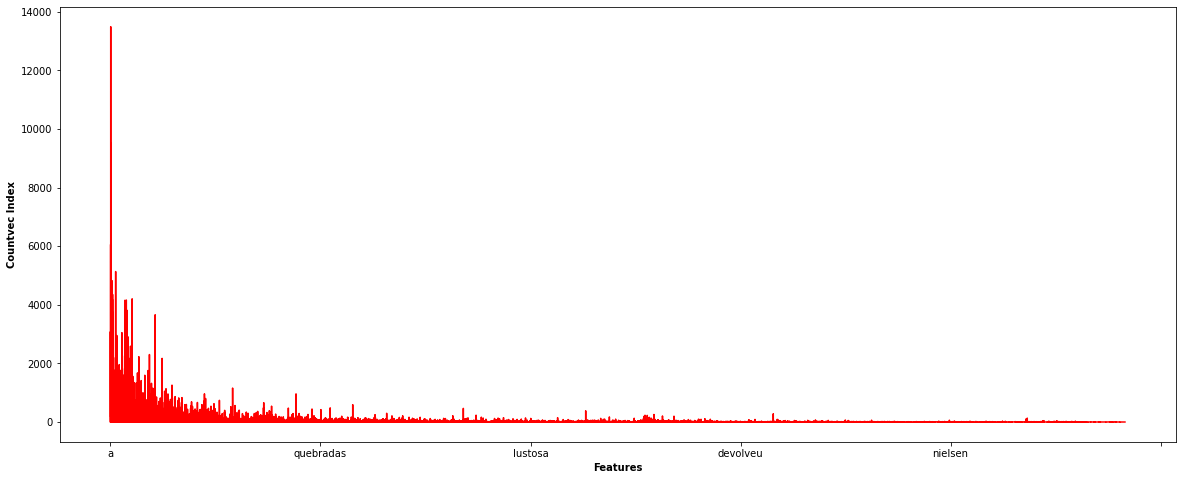

In [ ]:
plt.figure(figsize=(20,8))
sum_countvec_indexes.plot(c='red')
plt.xlabel('Features', fontweight='bold')
plt.ylabel('Countvec Index', fontweight='bold');

In [ ]:
sum_countvec_indexes.describe()

count    48302.000000
mean        23.802534
std        153.243268
min          0.000000
25%          1.000000
50%          2.000000
75%          8.000000
max      13486.000000
dtype: float64

In [ ]:
sum_countvec_indexes[sum_countvec_indexes > 31]

vacinação    3083
toda          613
população    2790
abrasco      1787
desde        1445
             ... 
ltd            48
sódio          33
rotatório      34
fore           36
wikimedia      32
Length: 4927, dtype: int64

In [ ]:
top_10percent_words = sum_countvec_indexes[sum_countvec_indexes > 31]

In [ ]:
sum_countvec_indexes[sum_countvec_indexes > 2]

vacinação     3083
toda           613
população     2790
quilombola      14
pautas          12
              ... 
doctors          3
maca             3
reale            4
jonestown        4
luix             3
Length: 23606, dtype: int64

In [ ]:
top_50percent_words = sum_countvec_indexes[sum_countvec_indexes > 2]

In [ ]:
top_50percent_words.sort_values(ascending = False).head(30)

saúde          13486
covid           9499
19              8842
pandemia        6058
pessoas         5133
brasil          4824
ser             4354
vacina          4203
sobre           4186
contra          4163
vacinas         4154
doses           3811
país            3741
países          3659
ainda           3621
casos           3587
vacinação       3083
milhões         3048
presidente      2951
feira           2911
governo         2857
população       2790
mil             2778
segundo         2740
em              2732
disse           2664
anos            2600
coronavírus     2587
mortes          2456
nacional        2393
dtype: int64

In [ ]:
vocabulario = top_50percent_words.index.tolist()
#vocabulario = top_10percent_words.index.tolist(). This case made the model worse

In [ ]:
vocabulario

['vacinação',
 'toda',
 'população',
 'quilombola',
 'pautas',
 'debatidas',
 'abrasco',
 'desde',
 'começo',
 'pandemia',
 'meio',
 'gt',
 'racismo',
 'saúde',
 'enfrenta',
 'novos',
 'desafios',
 'nesta',
 'semana',
 'ministro',
 'supremo',
 'tribunal',
 'federal',
 'edson',
 'fachin',
 'determinou',
 'quilombolas',
 'vivem',
 'comunidades',
 'incluídos',
 'plano',
 'nacional',
 'imunização',
 'pni',
 'enfrentamento',
 'epidemia',
 'covid',
 '19',
 'prazo',
 'união',
 'resolva',
 'situação',
 '15',
 'dias',
 'esta',
 'determinação',
 'resposta',
 'pedidos',
 'esclarecimentos',
 'arguição',
 'descumprimento',
 'preceito',
 'fundamental',
 '742',
 'denuncia',
 'estrutural',
 'diversas',
 'formas',
 'exclusão',
 'social',
 'vividas',
 'grupo',
 'ainda',
 'neste',
 'contexto',
 'além',
 'falta',
 'dados',
 'atuais',
 'mapeamento',
 'brasil',
 'governo',
 'usado',
 'censo',
 '2010',
 'absurda',
 'exigir',
 'comprove',
 'residência',
 'comunidade',
 'inclusão',
 'em',
 'recente',
 'entrevi

### Preparing train and test datasets
 (now with the 50% more popular words, i.e. words with at least 3 occurrences)

In [ ]:
# importing true and fake news datasets
df_true_news = countvec_texts.set_index('Unnamed: 0')
df_true_news_test = countvec_texts_test.set_index('Unnamed: 0')
df_fake_news = countvec_fake.set_index('Unnamed: 0')

# setting dataset features based on words with frequeny > 2
df_true_news = df_true_news[vocabulario]
df_true_news_test = df_true_news_test[vocabulario]
df_fake_news = df_fake_news[vocabulario]

# adding true or fake news labels (-1 = fake, 1 = true)
df_true_news['label_class'] = 1
df_true_news_test['label_class'] = 1
df_fake_news['label_class'] = -1

# setting training datasets
X_train = df_true_news.drop(['label_class'], axis = 1)
y_train = df_true_news['label_class']

# joining 40 true news with 40 fake for test dataset
df_test = df_fake_news.append(df_true_news_test.sample(n=40, random_state=42))
X_test = df_test.drop(['label_class'], axis = 1)
y_test = df_test['label_class']

### Choosing ideal trade-off with different parameters

Since we can't rely on GridSearch, here we are analying our results based on Nu parameter to decide which trade-off we wish to priorize (precision vs recall). [What is the nu parameter?](https://stackoverflow.com/questions/11230955/what-is-the-meaning-of-the-nu-parameter-in-scikit-learns-svm-class)

####Applying SVM, nu = 0.1

In [ ]:
one_class_svm = OneClassSVM(gamma='auto', nu = 0.1, verbose = True)

one_class_svm.fit(X_train)

y_pred = one_class_svm.predict(X_test)

print(classification_report(y_test, y_pred))

[LibSVM]              precision    recall  f1-score   support

          -1       0.69      0.23      0.34        40
           1       0.54      0.90      0.67        40

    accuracy                           0.56        80
   macro avg       0.61      0.56      0.51        80
weighted avg       0.61      0.56      0.51        80



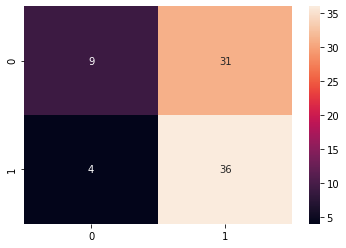

In [ ]:
sns.heatmap(confusion_matrix(y_test,y_pred), annot = True)

#### Applying SVM, nu = 0.3

In [ ]:
one_class_svm = OneClassSVM(gamma='auto', nu = 0.3, verbose = True)

one_class_svm.fit(X_train)

y_pred = one_class_svm.predict(X_test)

print(classification_report(y_test, y_pred))

[LibSVM]              precision    recall  f1-score   support

          -1       0.67      0.40      0.50        40
           1       0.57      0.80      0.67        40

    accuracy                           0.60        80
   macro avg       0.62      0.60      0.58        80
weighted avg       0.62      0.60      0.58        80



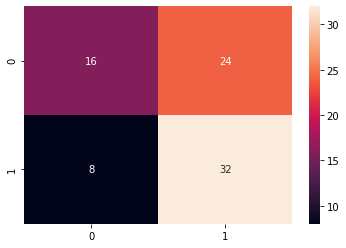

In [ ]:
sns.heatmap(confusion_matrix(y_test,y_pred), annot = True)

####Applying SVM, nu = 0.4 [Best trade-off score]

In [ ]:
one_class_svm = OneClassSVM(gamma='auto', nu = 0.4, verbose = True)

one_class_svm.fit(X_train)

y_pred = one_class_svm.predict(X_test)

print(classification_report(y_test, y_pred))

[LibSVM]              precision    recall  f1-score   support

          -1       0.70      0.47      0.57        40
           1       0.60      0.80      0.69        40

    accuracy                           0.64        80
   macro avg       0.65      0.64      0.63        80
weighted avg       0.65      0.64      0.63        80



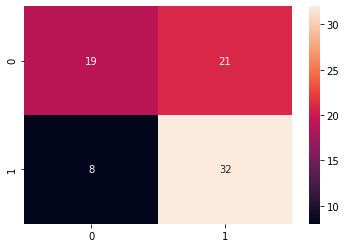

In [ ]:
sns.heatmap(confusion_matrix(y_test,y_pred), annot = True)

####Applying SVM, nu = 0.45

In [ ]:
one_class_svm = OneClassSVM(gamma='auto', nu = 0.45, verbose = True)

one_class_svm.fit(X_train)

y_pred = one_class_svm.predict(X_test)

print(classification_report(y_test, y_pred))

[LibSVM]              precision    recall  f1-score   support

          -1       0.65      0.50      0.56        40
           1       0.59      0.72      0.65        40

    accuracy                           0.61        80
   macro avg       0.62      0.61      0.61        80
weighted avg       0.62      0.61      0.61        80



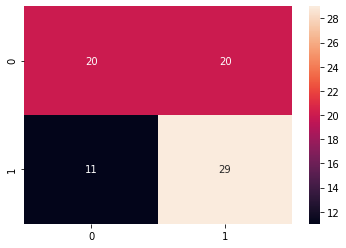

In [ ]:
sns.heatmap(confusion_matrix(y_test,y_pred), annot = True)

####Applying SVM, nu = 0.5

In [ ]:
one_class_svm = OneClassSVM(gamma='auto', nu = 0.5, verbose = True)

one_class_svm.fit(X_train)

y_pred = one_class_svm.predict(X_test)

print(classification_report(y_test, y_pred))

[LibSVM]              precision    recall  f1-score   support

          -1       0.63      0.55      0.59        40
           1       0.60      0.68      0.64        40

    accuracy                           0.61        80
   macro avg       0.61      0.61      0.61        80
weighted avg       0.61      0.61      0.61        80



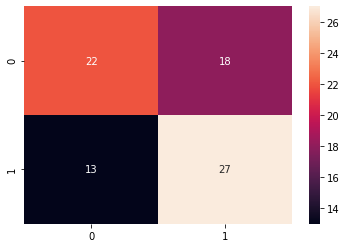

In [ ]:
sns.heatmap(confusion_matrix(y_test,y_pred), annot = True)

####Applying SVM, nu = 0.7

In [ ]:
one_class_svm = OneClassSVM(gamma='auto', nu = 0.7, verbose = True)

one_class_svm.fit(X_train)

y_pred = one_class_svm.predict(X_test)

print(classification_report(y_test, y_pred))

[LibSVM]              precision    recall  f1-score   support

          -1       0.53      0.62      0.57        40
           1       0.55      0.45      0.49        40

    accuracy                           0.54        80
   macro avg       0.54      0.54      0.53        80
weighted avg       0.54      0.54      0.53        80



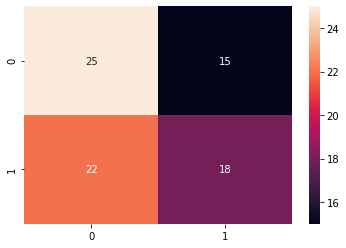

In [ ]:
sns.heatmap(confusion_matrix(y_test,y_pred), annot = True)

####Applying SVM, nu = 1.0

In [ ]:
one_class_svm = OneClassSVM(gamma='auto', nu = 1, verbose = True)

one_class_svm.fit(X_train)

y_pred = one_class_svm.predict(X_test)

print(classification_report(y_test, y_pred))

[LibSVM]              precision    recall  f1-score   support

          -1       0.50      1.00      0.67        40
           1       0.00      0.00      0.00        40

    accuracy                           0.50        80
   macro avg       0.25      0.50      0.33        80
weighted avg       0.25      0.50      0.33        80



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


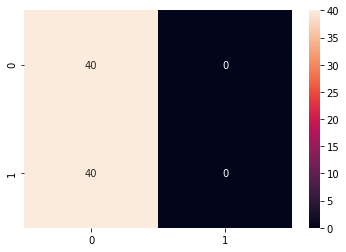

In [ ]:
sns.heatmap(confusion_matrix(y_test,y_pred), annot = True)

###Rebalancing train (80%) and test (20%) datasets

In [ ]:
# importing true and fake news datasets
df_true_news = countvec_texts.set_index('Unnamed: 0')
df_true_news_test = countvec_texts_test.set_index('Unnamed: 0')
df_fake_news = countvec_fake.set_index('Unnamed: 0')

# setting dataset features based on words with frequeny > 2
df_true_news = df_true_news[vocabulario]
df_true_news_test = df_true_news_test[vocabulario]
df_fake_news = df_fake_news[vocabulario]

# adding true or fake news labels (-1 = fake, 1 = true)
df_true_news['label_class'] = 1
df_true_news_test['label_class'] = 1
df_fake_news['label_class'] = -1

# setting training datasets
X_train = df_true_news.drop(['label_class'], axis = 1)
y_train = df_true_news['label_class']

# joining 40 true news with 40 fake for test dataset
df_test = df_fake_news.append(df_true_news_test.sample(n=275, random_state=42))
X_test = df_test.drop(['label_class'], axis = 1)
y_test = df_test['label_class']

In [ ]:
one_class_svm = OneClassSVM(gamma='auto', nu = 0.4, verbose = True)

one_class_svm.fit(X_train)

y_pred = one_class_svm.predict(X_test)

print(classification_report(y_test, y_pred))

[LibSVM]              precision    recall  f1-score   support

          -1       0.17      0.47      0.25        40
           1       0.90      0.65      0.76       275

    accuracy                           0.63       315
   macro avg       0.53      0.56      0.50       315
weighted avg       0.80      0.63      0.69       315



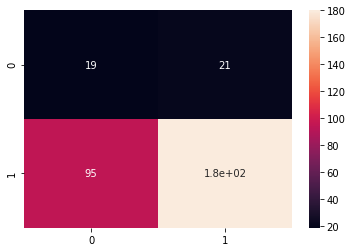

In [ ]:
sns.heatmap(confusion_matrix(y_test,y_pred), annot = True)

When we select 80% of our dataset as true news, and 20% as true and fake news, the model increases precision for true news, and decrease drastically the precision for fake news. 

###Rebalancing train (2981) and test (40 fake and 40 true) datasets

In [ ]:
# importing true and fake news datasets
df_true_news = countvec_texts.set_index('Unnamed: 0')
df_true_news_test = countvec_texts_test.set_index('Unnamed: 0')
df_fake_news = countvec_fake.set_index('Unnamed: 0')

# setting dataset features based on words with frequeny > 2
df_true_news = df_true_news[vocabulario]
df_true_news_test = df_true_news_test[vocabulario]
df_fake_news = df_fake_news[vocabulario]

# adding true or fake news labels (-1 = fake, 1 = true)
df_true_news['label_class'] = 1
df_true_news_test['label_class'] = 1
df_fake_news['label_class'] = -1

# joining 40 true news with 40 fake for test dataset
drop_index = df_true_news_test.sample(n=40, random_state=42).index
df_test = df_fake_news.append(df_true_news_test.sample(n=40, random_state=42))
df_true_news_test.drop(index= drop_index, inplace= True)
df_true_news_total = df_true_news.append(df_true_news_test)

# setting training datasets
X_train = df_true_news_total.drop(['label_class'], axis = 1)Z
y_train = df_true_news['label_class']

X_test = df_test.drop(['label_class'], axis = 1)
y_test = df_test['label_class']

In [ ]:
X_train.shape

(2981, 23606)

In [ ]:
X_test.shape

(80, 23606)

In [ ]:
one_class_svm = OneClassSVM(gamma='auto', nu = 0.5, verbose = True)

one_class_svm.fit(X_train)

y_pred = one_class_svm.predict(X_test)

print(classification_report(y_test, y_pred))

[LibSVM]              precision    recall  f1-score   support

          -1       0.59      0.57      0.58        40
           1       0.59      0.60      0.59        40

    accuracy                           0.59        80
   macro avg       0.59      0.59      0.59        80
weighted avg       0.59      0.59      0.59        80



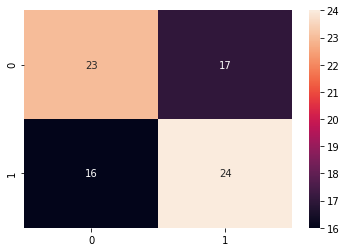

In [ ]:
sns.heatmap(confusion_matrix(y_test,y_pred), annot = True)

### Testing with DECISION FUNCTION

Here we are experimenting using One Class SVM Decision Function. This functions indicates the distance between the news text and the "hypersphere" that defines inliers vs outliers. We are experimenting to search for a viable way to, not simply define if the news is suspicious or not, but to quantify HOW MUCH SUSPICIOUS. Would be a way to do something similair the predict_proba function does for others machine learning models.

For training dataset

In [ ]:
train_distance = one_class_svm.decision_function(X_train)

predict_train = one_class_svm.predict(X_train)
df_train_dist = pd.DataFrame(predict_train)
df_train_dist['distance'] = train_distance
df_train_dist

,0,distance
0,-1,-9.079133
1,-1,-1.380324
2,1,8.516879
3,1,3.445925
4,-1,-33.307157
...,...,...
1255,1,6.717922
1256,1,7.356300
1257,-1,-0.835323
1258,-1,-17.266960


In [ ]:
scaler = MinMaxScaler(feature_range= (-1,1))
df_train_dist['distance_scaled'] = scaler.fit_transform(train_distance.reshape(-1,1))
df_train_dist

,0,distance,distance_scaled
0,-1,-9.079133,0.864244
1,-1,-1.380324,0.917880
2,1,8.516879,0.986832
3,1,3.445925,0.951503
4,-1,-33.307157,0.695452
...,...,...,...
1255,1,6.717922,0.974299
1256,1,7.356300,0.978746
1257,-1,-0.835323,0.921677
1258,-1,-17.266960,0.807201


For our test dataset

In [ ]:
test_distance = one_class_svm.decision_function(X_test)

predict_test = one_class_svm.predict(X_test)
df_test_dist = pd.DataFrame(predict_test)
df_test_dist['distance'] = test_distance
df_test_dist['distance_scaled'] = std_scaler.fit_transform(test_distance.reshape(-1,1))
df_test_dist

,0,distance,distance_scaled
0,1,6.895635,0.298067
1,1,7.596840,0.314741
2,-1,-4.042805,0.037971
3,1,8.467241,0.335437
4,-1,-15.323966,-0.230275
...,...,...,...
75,1,7.067126,0.302145
76,-1,-128.799307,-2.928514
77,1,7.445415,0.311140
78,1,6.992863,0.300379


## Wordcloud for true news

We wish to find a visual way to show what are our most frequent words on training dataset, in other words, the words that increase the odds of our model to call news as trustworthy.

In [ ]:
pip install wordcloud

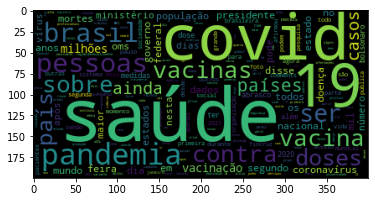

In [ ]:
wordcloud = WordCloud().generate_from_frequencies(sum_countvec_indexes)
plt.imshow(wordcloud)
#plt.figure(figsize=[30,30])


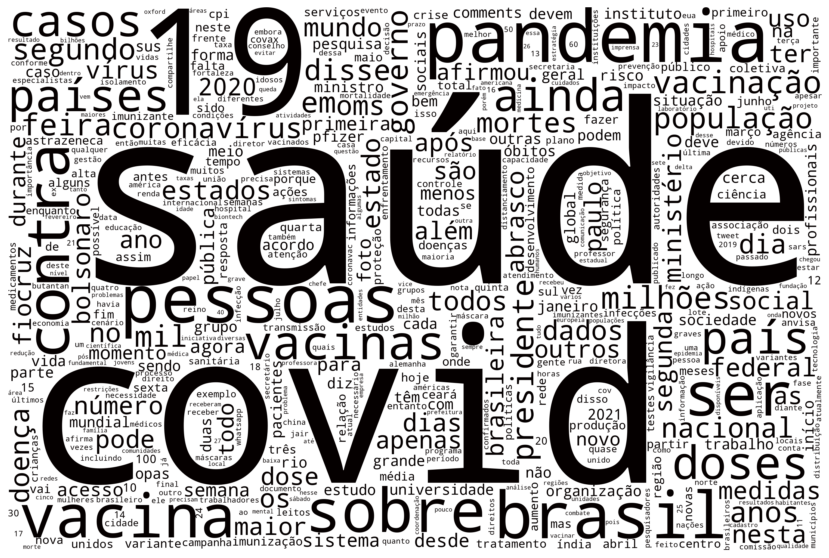

In [ ]:
def black_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(0,100%, 1%)")
wordcloud = WordCloud(background_color="white", width=3000, height=2000, max_words=500).generate_from_frequencies(sum_countvec_indexes)
wordcloud.recolor(color_func = black_color_func)
plt.figure(figsize=[15,10])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig('sum_countvec_indexes.png')

##Finding TRUSTWORTHY and SUSPICIOUS news examples

Here we are finding examples of news classified as suspicious vs trustworthy

In [ ]:
#importing the countvec df file from driver shared link

link = 'https://drive.google.com/file/d/1qTrp5bpdVZxI9YGZGCyJGo5P_7s-zVuT/view?usp=sharing'

# to get the id part of the file
id = link.split("/")[-2]
  
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('df_raw.csv')  
  
df_raw = pd.read_csv('df_raw.csv')
print(df_raw)

      Unnamed: 0  ...                               tokenized_texts_join
0              0  ...  diferentes cenários países afetados clima faze...
1              1  ...  em meados abril artigo avivah wittenberg cox p...
2              2  ...  matéria canal globo news desta segunda feira 2...
3              3  ...  em nota pública departamento medicina preventi...
4              4  ...  terça feira dia 7 quarta feira dia 8 quinta fe...
...          ...  ...                                                ...
1255        1255  ...  o ministro stf supremo tribunal federal alexan...
1256        1256  ...  o médico sanitarista ex presidente anvisa agên...
1257        1257  ...  o médico sanitarista claudio maierovitch disse...
1258        1258  ...  o agricultor franciberto vieira carneiro 47 di...
1259        1259  ...  uma pesquisa divulgada hoje conjuve conselho n...

[1260 rows x 11 columns]


In [ ]:
#importing the countvec df file from driver shared link

link = 'https://drive.google.com/file/d/15GccL4eLdINi0Nn7nD3M79qfa6bYYONC/view?usp=sharing'

# to get the id part of the file
id = link.split("/")[-2]
  
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('df_raw_test.csv')  
  
df_raw_test = pd.read_csv('df_raw_test.csv')
print(df_raw_test)

      Unnamed: 0  ...                               tokenized_texts_join
0              0  ...  a vacinação toda população quilombola pautas d...
1              1  ...  uma articulação inovadora reúne associações ci...
2              2  ...  graças gestão desastrosa pandemia covid 19 bra...
3              3  ...  no dia país atinge triste marca meio milhão mo...
4              4  ...  fila vacinação são paulo fotos roberto parizot...
...          ...  ...                                                ...
1756        2976  ...  todos moradores capital rio janeiro 50 anos de...
1757        2986  ...  membros sido chamado gabinete paralelo grupo i...
1758        2989  ...  uma pesquisa divulgada hoje conjuve conselho n...
1759        3015  ...  o governador maranhão flávio dino pcdob disse ...
1760        3019  ...  tales faria largou curso física formar jornali...

[1761 rows x 11 columns]


In [ ]:
#importing the countvec df file from driver shared link

link = 'https://drive.google.com/file/d/1OgiBW3WnAXPU08KhrhNMCFfm15q_AOkJ/view?usp=sharing'

# to get the id part of the file
id = link.split("/")[-2]
  
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('df_fake.csv')  
  
df_fake = pd.read_csv('df_fake.csv')
print(df_fake)

    Unnamed: 0  ...                               tokenized_texts_join
0            0  ...  em 21 fevereiro prefeito edinho silva pt redes...
1            1  ...  um sites têm reunido estudos efeitos ivermecti...
2            2  ...  infecção anterior vírus covid protege jovens r...
3            3  ...  rafael ramos 13h00 atualizado 16 07 2020 12h20...
4            4  ...  a indústria covid fetiche ciência políticos go...
5            5  ...  clique para ouvir a matéria ou pausar uma pesq...
6            6  ...  sobre 61 49 milhões pessoas mundo inteiro cont...
7            7  ...  a prefeitura cidade méxico divulgou estudo afi...
8            8  ...  a existência epidemia perigosa rápido progress...
9            9  ...  prefeito são lourenço zera internações covid g...
10          10  ...  a prefeitura cidade méxico informou nesta sext...
11          11  ...  governo noruega descarta lockdown nova onda co...
12          12  ...  governo alemão fabricou ciência justificar med...
13    

###TRUE news example

In [ ]:
df_raw.iloc[2,:]

Unnamed: 0                                                              2
title                   Demora no processamento de testes chega até tr...
description                                                           NaN
text                    Matéria do canal Globo News desta segunda-feir...
authors                                                  ['Thereza Reis']
date_published                                        2020-05-26 08:12:08
image                   https://www.abrasco.org.br/site/wp-content/upl...
source_domain                                          www.abrasco.org.br
url                     https://www.abrasco.org.br/site/noticias/espec...
tokenized_texts         ['matéria', 'canal', 'globo', 'news', 'desta',...
tokenized_texts_join    matéria canal globo news desta segunda feira 2...
Name: 2, dtype: object

In [ ]:
print('Título: ', df_raw.iloc[2,1])

Título:  Demora no processamento de testes chega até três meses no Rio de Janeiro


In [ ]:
df_raw.iloc[2,3]

'Matéria do canal Globo News desta segunda-feira, 25 de maio, tratou da situação da pandemia da Covid-19 no estado do Rio de Janeiro. Levantamento do canal, com base em dados divulgados pelo Ministério da Saúde e pela prefeitura do município do Rio de Janeiro, aponta que há atraso no processamento de testes, e que a demora no diagnóstico pode chegar a três meses. Gulnar Azevedo e Silva, presidente da Abrasco, foi entrevistada na reportagem e comentou sobre a defasagem nas notificações. “A política de transparência de informação é vital para que se possa de fato acompanhar a epidemia. Se a gente não tem um dado atualizado, se a gente não está tendo ideia de como a epidemia está se comportando no município do Rio de Janeiro e também na Baixada Fluminense, a gente não tem a menor condição, a menor tranquilidade de relaxar as regras”, afirmou a professora do Instituto de Medicina Social da Universidade do Estado do Rio de Janeiro (IMS/UERJ). Gulnar Azevedo alertou que “ainda não estamos na

###FAKE news example

In [ ]:
df_fake.iloc[4,:]

Unnamed: 0                                                              4
title                         A Indústria da Covid e o fetiche da ciência
description             Quanto de ciência existe nas diretrizes da OMS...
text                    A Indústria da Covid e o fetiche da ciência Po...
authors                                                                []
date_published                                        2020-04-28 09:14:17
image                   https://www.frontliner.com.br/content/images/2...
source_domain                                       www.frontliner.com.br
url                     https://www.frontliner.com.br/a-industria-da-c...
tokenized_texts         ['a', 'indústria', 'covid', 'fetiche', 'ciênci...
tokenized_texts_join    a indústria covid fetiche ciência políticos go...
Name: 4, dtype: object

In [ ]:
print('Título: ', df_fake.iloc[4,1])

Título:  A Indústria da Covid e o fetiche da ciência


In [ ]:
df_fake.iloc[4,8]

'https://www.frontliner.com.br/a-industria-da-covid-e-o-fetiche-da-ciencia/'

In [ ]:
df_fake.iloc[4,3]